In [1]:
import xarray as xr
import cartopy
import cmasher as cmr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import geopandas as gpd
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift
from mpl_toolkits.mplot3d import Axes3D
import glob
import seaborn as sns
import matplotlib.gridspec as gridspec

/home/estudiantes/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Cargando los resultados del cluster de HadISD

clus_Had=pd.read_csv("clusterinf_Had.csv")

In [3]:
#Seleccionando cada cluster
clus0=clus_Had.loc[clus_Had["cluster"]==0]
clus1=clus_Had.loc[clus_Had["cluster"]==1]

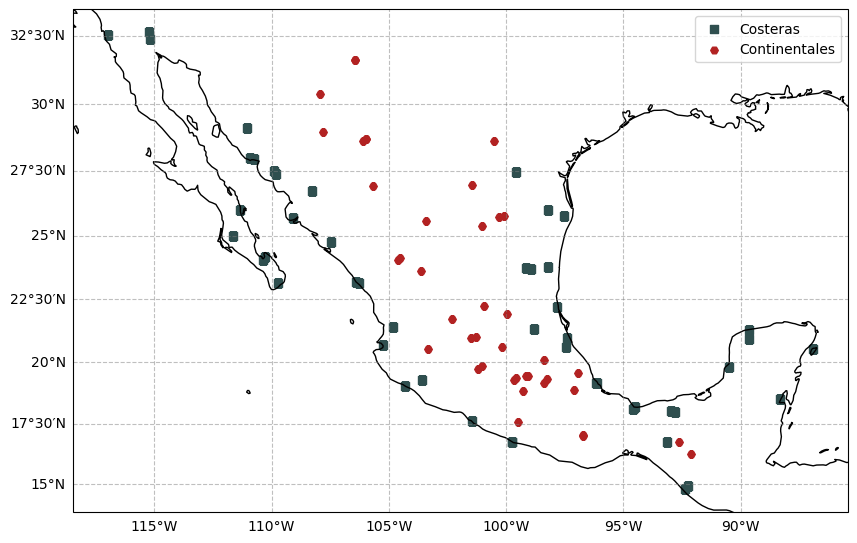

In [4]:
#Mostrando la clasificación
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.Mercator()})
# set_extent([lonmin,lonmax,latmin,latmax])
#ax.set_extent([-120, -90, 14, 33], crs=ccrs.PlateCarree()) #siempre tiene que llevar esto para un recorte
#ax.set_global
# fusion
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
#El cluster0 es lo más lejano a la costa,mientras que el cluster 1 es lo más cercano a la costa
sc=ax.scatter(clus0["Lon"].astype(float), clus0["lat"].astype(float),color='darkslategray', marker='s', s=30,label="Costeras", transform=ccrs.PlateCarree())
#for city, lat, lon in zip(estacion0.astype(str), cluster0["lat"].astype(float), cluster0["Lon"].astype(float)):
  #  ax.text(lon, lat, city, fontsize=12, ha="right",color='blue')
ax.scatter(clus1["Lon"].astype(float), clus1["lat"].astype(float),color='firebrick', marker='H', s=30,label='Continentales', transform=ccrs.PlateCarree())
#ax.scatter(cluster2["Lon"].astype(float), cluster2["lat"].astype(float),color='pink', marker='o', label='Cluster1', transform=ccrs.PlateCarree())
#ax.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='Centros de Clusters',)
#ax.scatter(x,y)
#cbar=plt.colorbar(cs,orientation='vertical',fraction=0.1,extend="both",shrink=0.8,label='TW [$^{\circ}$C]')
#plt.title("Clusters creados con el método Kmeans")
plt.legend()
plt.savefig("Metodo_cluster.svg",bbox_inches="tight")
plt.show()

In [5]:
#Cargando los datos de ERA5-Land

# Usar glob para seleccionar todos los archivos CSV en la ruta
archivos_csv = glob.glob("/home/andreagvc/data/ERA/ERA/aux_csv/*.csv")

# Leer y concatenar todos los archivos CSV
df_concatenado = pd.concat([pd.read_csv(f) for f in archivos_csv], ignore_index=True)

# Ver el DataFrame concatenado
print(df_concatenado)

               ERA5      HadSID                           time    var     SID
0         11.540000  288.730000  1990-01-01T21:00:00.000000000  TWB_d  761600
1          6.580000  281.280000  1990-01-02T12:00:00.000000000  TWB_d  761600
2          6.500000  281.030000  1990-01-02T15:00:00.000000000  TWB_d  761600
3         11.180000  284.120000  1990-01-02T18:00:00.000000000  TWB_d  761600
4         11.800000  287.010000  1990-01-02T21:00:00.000000000  TWB_d  761600
...             ...         ...                            ...    ...     ...
17382076   0.014425    0.015457  2008-12-31T12:00:00.000000000    q_d  769043
17382077   0.014879    0.016414  2008-12-31T15:00:00.000000000    q_d  769043
17382078   0.015098    0.015411  2008-12-31T18:00:00.000000000    q_d  769043
17382079   0.014240    0.015411  2008-12-31T19:00:00.000000000    q_d  769043
17382080   0.014716    0.017486  2008-12-31T21:00:00.000000000    q_d  769043

[17382081 rows x 5 columns]


In [6]:
df_concatenado["time"]=pd.to_datetime(df_concatenado['time'])
#Encontrando un valor por año

#Cambiando el índice
# Set time column as index
df_concatenado = df_concatenado.set_index('time')

In [7]:
#Variables
Ts=df_concatenado.loc[df_concatenado["var"]=="T_d"].reset_index()
Tws=df_concatenado.loc[df_concatenado["var"]=="TWB_d"].reset_index()
qs=df_concatenado.loc[df_concatenado["var"]=="q_d"].reset_index()

In [8]:
#Separando los periodos
Tws1=Tws.loc[Tws.time.dt.year<2001]
Tws2=Tws.loc[Tws.time.dt.year>2000]

In [9]:
Tws1

,time,ERA5,HadSID,var,SID
0,1990-01-01 21:00:00,11.54,288.73,TWB_d,761600
1,1990-01-02 12:00:00,6.58,281.28,TWB_d,761600
2,1990-01-02 15:00:00,6.50,281.03,TWB_d,761600
3,1990-01-02 18:00:00,11.18,284.12,TWB_d,761600
4,1990-01-02 21:00:00,11.80,287.01,TWB_d,761600
...,...,...,...,...,...
5620313,1997-12-31 03:00:00,19.60,294.90,TWB_d,769030
5620314,1997-12-31 06:00:00,17.46,294.04,TWB_d,769030
5620315,1997-12-31 09:00:00,16.59,292.31,TWB_d,769030
5620316,1997-12-31 12:00:00,15.62,292.32,TWB_d,769030


In [10]:
#periodo (1979-2000)
lista1= Tws1['ERA5'].tolist() + (Tws1['HadSID']-273.15).tolist()+Tws2['ERA5'].tolist() + (Tws2['HadSID']-273.15).tolist()

data1= ["1979-2000"]*len(Tws1.ERA5)+["1979-2000"]*len(Tws1.ERA5)+["2001-2023"]*len(Tws2.ERA5)+["2001-2023"]*len(Tws2.ERA5)

var1=["ERA5-Land"]*len(Tws1.ERA5)+["HadISD"]*len(Tws1.ERA5)+["ERA5-Land"]*len(Tws2.ERA5)+["HadISD"]*len(Tws2.ERA5)

In [11]:
df_tw = pd.DataFrame({
    'Variables': var1,
    'TW': lista1,
    'Datos':data1,
    
})

In [12]:
df_tw

,Variables,TW,Datos
0,ERA5-Land,11.54,1979-2000
1,ERA5-Land,6.58,1979-2000
2,ERA5-Land,6.50,1979-2000
3,ERA5-Land,11.18,1979-2000
4,ERA5-Land,11.80,1979-2000
...,...,...,...
11588049,HadISD,21.88,2001-2023
11588050,HadISD,23.66,2001-2023
11588051,HadISD,23.27,2001-2023
11588052,HadISD,23.27,2001-2023


#Resample horario
h_Ts=Ts.resample("H").mean(["HadSID","ERA5"])
h_Tws=Tws.resample("H").mean(["HadSID","ERA5"])
h_qs=qs.resample("H").mean(["HadSID","ERA5"])

#Resample anual
an_Ts=h_Ts.resample("Y").mean(["HadSID","ERA5"])
an_Tws=h_Tws.resample("Y").mean(["HadSID","ERA5"])
an_qs=h_qs.resample("Y").mean(["HadSID","ERA5"])

(0.0, 35.0)

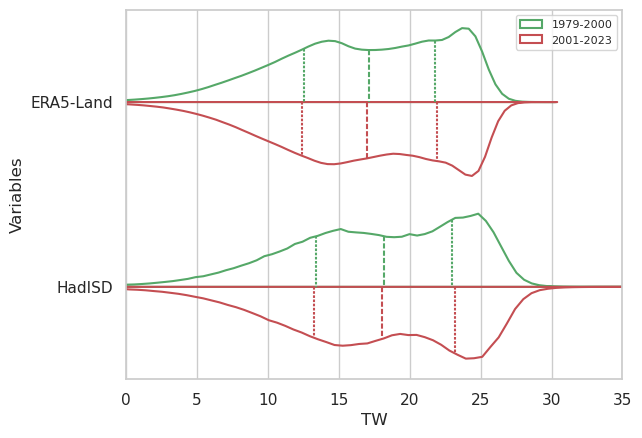

In [13]:
sns.set_theme(style="whitegrid")
sns.violinplot(data=df_tw, x="TW", y="Variables", hue="Datos",fill=False, split=True, inner="quart",palette={"1979-2000": "g", "2001-2023": "r"})
plt.legend(fontsize=8)
plt.xlim(0,35)

In [14]:
#Creando las listas para formar los violines de temperatura
lista= Ts['ERA5'].tolist() + Ts['HadSID'].tolist()

data= ["ERA"]*len(Ts.ERA5)+["HadISD"]*len(Ts.ERA5)

var=["T"]*len(Ts.ERA5)+["T"]*len(Ts.ERA5)

In [15]:
#Creando las listas para formr el violín de humedad
listaq= qs['ERA5'].tolist() + qs['HadSID'].tolist()

dataq= ["ERA"]*len(Ts.ERA5)+["HadISD"]*len(Ts.ERA5)

varq=["qs"]*len(Ts.ERA5)+["qs"]*len(Ts.ERA5)

In [16]:
df_temps = pd.DataFrame({
    'Variables': var,
    'Valores de T': lista,
    'Datos':data,
    
})

In [17]:
df_q=pd.DataFrame({
    'Variables': varq,
    'Humedad específica': listaq,
    'Datos':dataq,
    
})

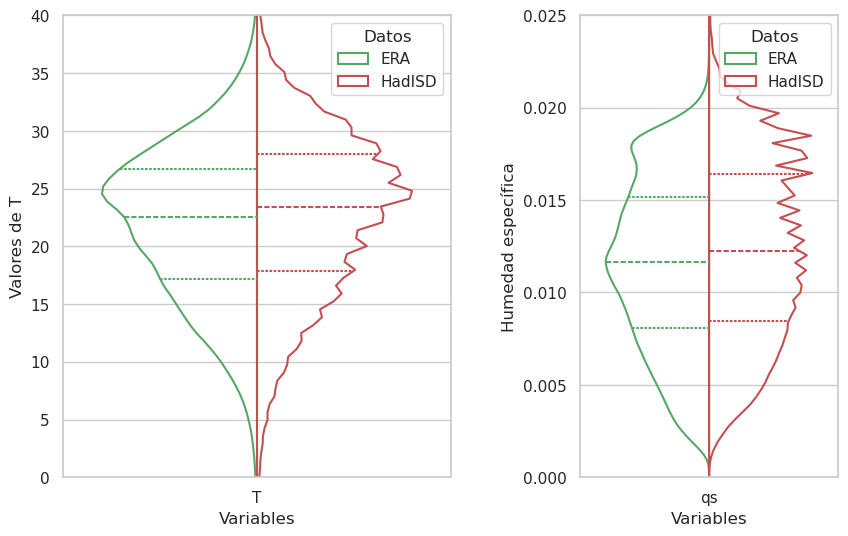

In [18]:
# Crear un objeto Figure
fig = plt.figure(figsize=(10, 6))

# Definir la estructura de subgráficas usando GridSpec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])

# Crear las subgráficas (Axes)
ax1 = fig.add_subplot(gs[0])  # Primer panel (más grande)
ax2 = fig.add_subplot(gs[1])  # Segundo panel (más pequeño)


sns.set_theme(style="whitegrid")
sns.violinplot(data=df_temps, x="Variables", y="Valores de T", hue="Datos", ax=ax1,fill=False, split=True, inner="quart",palette={"ERA": "g", "HadISD": "r"})
ax1.set_ylim(0,40)

sns.set_theme(style="whitegrid")
sns.violinplot(data=df_q, x="Variables", y="Humedad específica", hue="Datos",ax=ax2, fill=False, split=True, inner="quart",palette={"ERA": "g", "HadISD": "r"})
ax2.set_ylim(0,0.025)

plt.subplots_adjust(wspace=0.4)


In [19]:
Ts.ERA5

0          20.730865
1           7.684967
2           7.574127
3          17.109772
4          19.670807
             ...    
5794022    22.168365
5794023    27.100677
5794024    29.569000
5794025    29.611969
5794026    29.452301
Name: ERA5, Length: 5794027, dtype: float64

In [20]:
Tws[["ERA5","HadSID"]].to_csv("ex.csv")

In [21]:
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [23]:

# Crear datos de ejemplo

data = pd.DataFrame({
    
    "ERA5-Land": Ts.ERA5,  # Distribución normal
    "HadISD": Ts.HadSID,
    
})


data1 = pd.DataFrame({
    
    "ERA5-Land": qs.ERA5*1000,  # Distribución normal
    "HadISD": qs.HadSID*1000,
    
})

data2 = pd.DataFrame({
    
    "ERA5-Land": Tws.ERA5,  # Distribución normal
    "HadISD": Tws.HadSID-273.15,
    
})

In [24]:
data2

,ERA5-Land,HadISD
0,11.54,15.58
1,6.58,8.13
2,6.50,7.88
3,11.18,10.97
4,11.80,13.86
...,...,...
5794022,20.50,21.88
5794023,22.27,23.66
5794024,23.08,23.27
5794025,22.50,23.27


In [32]:

# Convertir a formato largo para seaborn
data_melted = data.melt(var_name="", value_name="Valor")
data_melted1 = data1.melt(var_name="Variable", value_name="Valor")
data_melted2 = data2.melt(var_name="Variable", value_name="Valor")

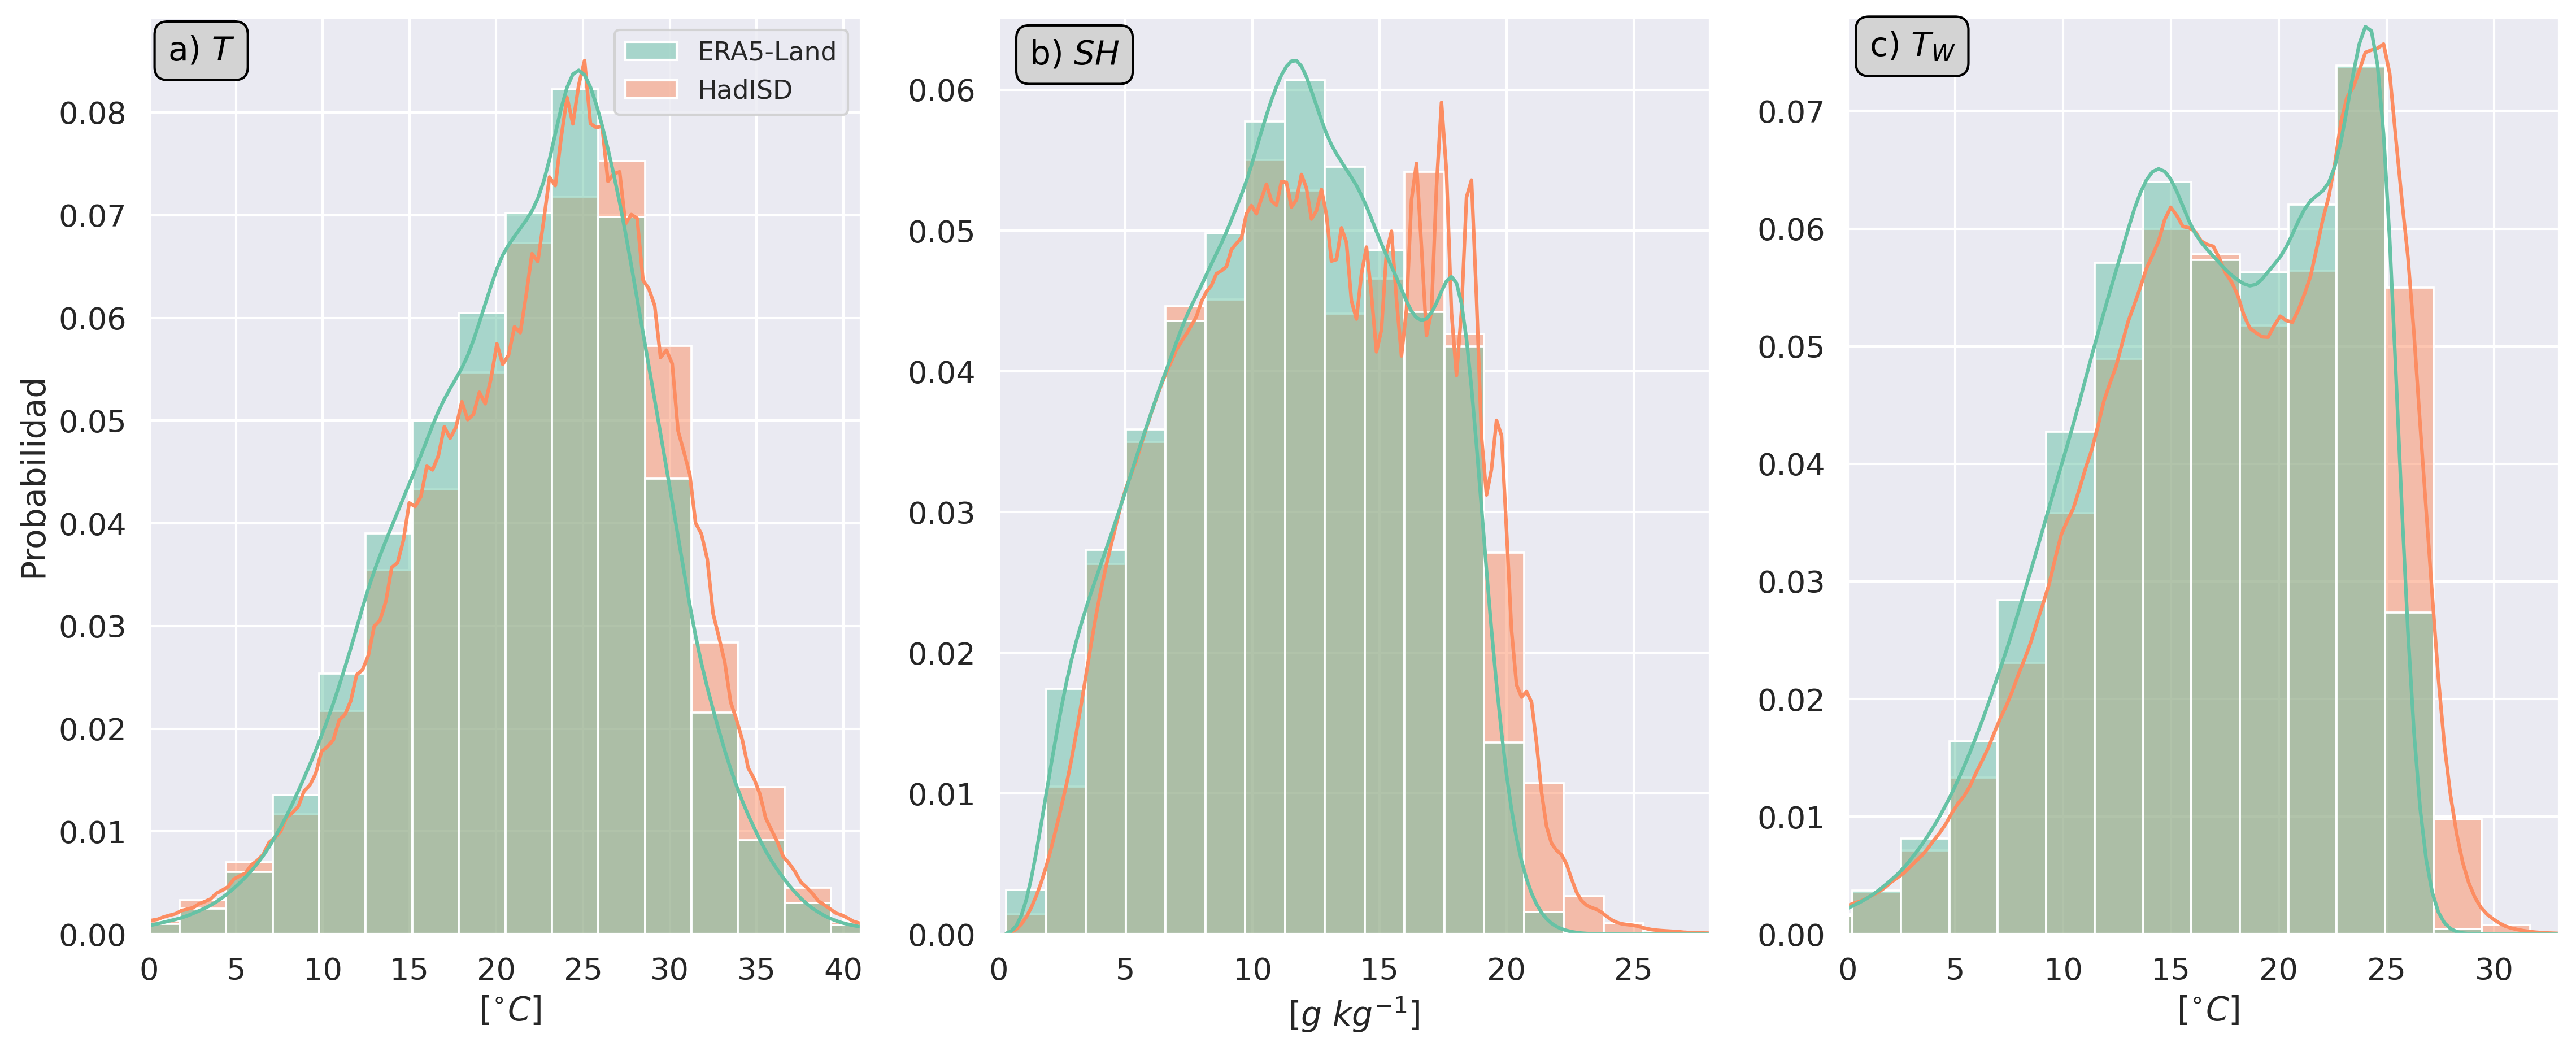

In [37]:
#Crear la gráfica con Seaborn

plt.figure(figsize=(15, 6),dpi=300)

plt.subplot(1,3,1)
sns.histplot(data=data_melted, x="Valor", hue="", kde=True,stat="probability" ,legend=True,bins=25, palette="Set2",kde_kws={'bw_adjust':1.25})
plt.xlim([0,41])
#plt.legend(loc="upper left")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Estilizar
plt.xlabel(" $[^{\circ}C]$",fontsize=14)
plt.text(3, 0.086, "a) $T$", fontsize=14, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))

plt.ylabel("Probabilidad",fontsize=14)

plt.subplot(1,3,2)
sns.histplot(data=data_melted1, x="Valor", hue="Variable", kde=True, stat="probability",bins=25, legend=False,palette="Set2",kde_kws={'bw_adjust':1.25})
plt.xlim([0,28])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.text(3, 0.0625, "b) $SH$", fontsize=14, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
# Estilizar
plt.xlabel("[$g$ $kg^{-1}$]",fontsize=14)
plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(1,3,3)
sns.histplot(data=data_melted2, x="Valor", hue="Variable", kde=True, stat="probability",bins=25, legend=False,palette="Set2",kde_kws={'bw_adjust':1.25})
plt.xlim([0,33])
plt.ylim([0,0.078])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.text(3, 0.0755, "c) $T_{W}$", fontsize=14, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
# Estilizar
plt.tight_layout(h_pad=0,pad=0)
plt.xlabel(" $[^{\circ}C]$",fontsize=14)
plt.ylabel("Probabilidad",fontsize=14,color="white")
plt.savefig("dist_ERAvsHAD.svg",bbox_inches="tight",dpi=300)
plt.show()

In [27]:
#763050
qs.loc[qs.index==763050]

,time,ERA5,HadSID,var,SID
763050,2018-04-28,0.005408,0.00619,q_d,761600


In [28]:
#Ya que estamos considerando que los valores de ERA5-Land son para cada estación,
#la distancia a la costa es la misma que la de HadISD
dis_ERA=clus_Had["distancia_costa"]

#Se hará los cluster de acuerdo a la distancia de las estaciones y los 2m de ERA
ele_Had=clus_Had["elevacion"]

n = len(Ts.ERA5) # Número de filas
ele_ERA5 =[2]*n

In [29]:
#Generando un data frame que me guarde las variables para el clustering, para este caso sería la distancia a la costa y el valor de la humedad específica
clusdata_ERA = pd.DataFrame({
    'distancia_costa': dis_ERA,
    'elevacion_Had': ele_Had,
    'elevacion_ERA':ele_ERA5,
    'temperatura':Ts.ERA5,
    'lat':clus_Had["lat"],
    'Lon':clus_Had["Lon"],
    'humedad':qs.ERA5,
    "ID":np.unique(df_concatenado.SID)
})
clusdata_ERA

ValueError: All arrays must be of the same length

In [ ]:
#Eliminando las estaciones sin valores
clusdata_ERA=clusdata_ERA.dropna()

In [ ]:
#Generando los clusters
# Step 3: Prepare the input features for K-means
features = clusdata_ERA[["distancia_costa","temperatura","elevacion_Had"]]

# Step 4: Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Aplicar K-means con 3 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled_features)

# Agregar las etiquetas de los clusters al DataFrame
clusdata_ERA['cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_

# Mostrar los resultados
print("Centroides:\n", centroids)
print("Etiquetas de los clústeres:", kmeans.labels_)

In [ ]:

#Generando los clusters
# Step 3: Prepare the input features for K-means
features = clusdata_ERA[["distancia_costa","temperatura","elevacion_Had"]]

# Step 4: Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Aplicar K-means con 3 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled_features)

# Agregar las etiquetas de los clusters al DataFrame
clusdata_ERA['cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_

# Mostrar los resultados
print("Centroides:\n", centroids)
print("Etiquetas de los clústeres:", kmeans.labels_)

In [ ]:
clusdata_ERA.to_csv("clusterinf_ERA5.csv",index=False)

In [ ]:
clus_ERA=pd.read_csv("clusterinf_ERA5.csv")

In [ ]:
#Seleccionando cada cluster
clus0E=clus_ERA.loc[clus_ERA["cluster"]==0]
clus1E=clus_ERA.loc[clus_ERA["cluster"]==1]

In [ ]:
#Mostrando la clasificación

fig = plt.figure(figsize=(10, 5),dpi=120)
# set_extent([lonmin,lonmax,latmin,latmax])
#ax.set_extent([-120, -90, 14, 33], crs=ccrs.PlateCarree()) #siempre tiene que llevar esto para un recorte
#ax.set_global
# fusion
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
#El cluster0 es lo más lejano a la costa,mientras que el cluster 1 es lo más cercano a la costa
sc=ax.scatter(clus0["Lon"].astype(float), clus0["lat"].astype(float),color='darkslategray', marker='s', s=8,label='Cluster0 (cercano a la costa)', transform=ccrs.PlateCarree())
#for city, lat, lon in zip(estacion0.astype(str), cluster0["lat"].astype(float), cluster0["Lon"].astype(float)):
  #  ax.text(lon, lat, city, fontsize=12, ha="right",color='blue')
ax.scatter(clus1["Lon"].astype(float), clus1["lat"].astype(float),color='firebrick', marker='H', s=8,label='Cluster1 (lejano a la costa)', transform=ccrs.PlateCarree())
#ax.scatter(cluster2["Lon"].astype(float), cluster2["lat"].astype(float),color='pink', marker='o', label='Cluster1', transform=ccrs.PlateCarree())
#ax.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='Centros de Clusters',)
#ax.scatter(x,y)
#cbar=plt.colorbar(cs,orientation='vertical',fraction=0.1,extend="both",shrink=0.8,label='TW [$^{\circ}$C]')
plt.title("Clusters HadISD")
plt.legend(fontsize=7, loc="lower left")
#plt.savefig("Metodo_cluster.svg")


ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
#El cluster0 es lo más lejano a la costa,mientras que el cluster 1 es lo más cercano a la costa
sc=ax.scatter(clus0E["Lon"].astype(float), clus0E["lat"].astype(float),color='firebrick', marker='H', s=8,label='Cluster0 (lejano a la costa)', transform=ccrs.PlateCarree())
#for city, lat, lon in zip(estacion0.astype(str), cluster0["lat"].astype(float), cluster0["Lon"].astype(float)):
  #  ax.text(lon, lat, city, fontsize=12, ha="right",color='blue')
ax.scatter(clus1E["Lon"].astype(float), clus1E["lat"].astype(float),color='darkslategray', marker='s', s=8,label='Cluster1 (cercano a la costa)', transform=ccrs.PlateCarree())
#ax.scatter(cluster2["Lon"].astype(float), cluster2["lat"].astype(float),color='pink', marker='o', label='Cluster1', transform=ccrs.PlateCarree())
#ax.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='Centros de Clusters',)
#ax.scatter(x,y)
#cbar=plt.colorbar(cs,orientation='vertical',fraction=0.1,extend="both",shrink=0.8,label='TW [$^{\circ}$C]')
plt.title("Clusters ERA")
plt.legend(fontsize=7,loc="lower left")
#plt.savefig("Metodo_cluster.svg")
plt.show()

In [ ]:
clusdata_ERA

In [ ]:
titanic = sns.load_dataset("titanic")

In [ ]:
titanic

In [ ]:
lista = df_concatenado['ERA5'].values.tolist() + df_concatenado['HadSID'].values.tolist()
print(lista)

In [ ]:
valoresT

In [ ]:
p=df_concatenado.ERA5.reset_index()
p["ERA5"].values

In [ ]:
df=pd.DataFrame({
    'x': variable,
    'y':clusdata_temperatura,
    'elevacion_ERA':ele_ERA5,
    
})

In [ ]:
df_concatenado

In [ ]:
# Crear el gráfico de violín
plt.figure(figsize=(8,6))
sns.violinplot(x="species", y="bill_length_mm", data=penguins, palette="muted")

# Personalizar título
plt.title("Distribución del Largo del Pico por Especie", fontsize=14)
plt.show()

In [ ]:
df=pd.read_csv("IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

In [ ]:
#Cargando los datos con los que se harán los clusters
da_list=[]
for i,ii in enumerate(esta[1]):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999_estadisticos.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)
HAD=xr.concat(da_list,dim='estacion')

In [ ]:
HAD

In [ ]:
df_concatenado

In [ ]:
df=pd.DataFrame({
    'x': variable,
    'y':clusdata_temperatura,
    'elevacion_ERA':ele_ERA5,
    
})

In [ ]:
sns.violinplot(data=df_concatenado, x="var", y="HadSID", pallet="mullet")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt  # Librería para Raincloud Plots

# Generamos datos simulados
np.random.seed(42)
grupo1 = np.random.normal(50, 10, 300)  # Media 50, desviación 10
grupo2 = np.random.normal(60, 12, 300)  # Media 60, desviación 12

# Convertimos a un DataFrame en formato largo
df = pd.DataFrame({
    "Valor": np.concatenate([grupo1, grupo2]),
    "Grupo": ["Grupo 1"] * len(grupo1) + ["Grupo 2"] * len(grupo2)
})

# Configurar la figura
plt.figure(figsize=(10, 6))

# Crear el Raincloud Plot horizontal y sin separación
pt.RainCloud(data=df, x="Valor", y=None, hue="Grupo", 
             palette="coolwarm", width_viol=0.7, width_box=0.1, 
              alpha=0.6, jitter=0.1)

# Estilizar
plt.title("Raincloud Plot - Distribuciones Solapadas (Horizontal)")
plt.xlabel("Valor")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Mostrar la gráfica
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt  # Librería para Raincloud Plots

# Generamos datos simulados
np.random.seed(42)
grupo1 = np.random.normal(50, 10, 300)  # Media 50, desviación 10
grupo2 = np.random.normal(60, 12, 300)  # Media 60, desviación 12

# Convertimos a un DataFrame en formato largo para Seaborn
df = pd.DataFrame({
    "Valor": np.concatenate([grupo1, grupo2]),
    "Grupo": ["Grupo 1"] * len(grupo1) + ["Grupo 2"] * len(grupo2)
})

# Configurar la figura
plt.figure(figsize=(8, 6))

# Crear el Raincloud Plot con ptitprince
pt.RainCloud(data=df, x="Grupo", y="Valor", hue="Grupo", 
             palette="coolwarm", width_viol=0.7, width_box=0.2, 
         alpha=0.6, jitter=0.1, dodge=True)

# Estilizar
plt.title("Raincloud Plot - Comparación de Distribuciones")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostrar la gráfica
plt.show()
